In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

federal_state_translation = {
    "BB": "Brandenburg",
    "BE": "Berlin",
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "HB": "Bremen",
    "HE": "Hessen",
    "HH": "Hamburg",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SH": "Schleswig-Holstein",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "TH": "Thüringen",
    "DE-total": "Deutschland",
}
inv_fst = {v: k for k, v in federal_state_translation.items()}

df = pd \
.read_csv("data/fertility_de.tsv",
          sep="\t",
          usecols=['States', 'Fertilitätsrate pro Frau'])

df['Deaths_Per_Million'] = [entorb.to_dataframe(inv_fst[area])['Cases_Per_Million'].median() for area in df['States']]
display(df)
corr = df.corr()**2
corr.style.background_gradient(cmap='Blues')

,States,Fertilitätsrate pro Frau,Deaths_Per_Million
0,Brandenburg,1.69,1364.5
1,Niedersachsen,1.68,1686.5
2,Sachsen,1.66,1335.0
3,Bremen,1.63,2429.5
4,Thüringen,1.63,1515.5
5,Sachsen-Anhalt,1.62,844.5
6,Nordrhein-Westfalen,1.61,2377.5
7,Schleswig-Holstein,1.61,1086.0
8,Rheinland-Pfalz,1.60,1706.5
9,Baden-Württemberg,1.59,3209.0


,Fertilitätsrate pro Frau,Deaths_Per_Million
Fertilitätsrate pro Frau,1.000000,0.196600
Deaths_Per_Million,0.196600,1.000000


In [2]:
from qwikidata.sparql \
import return_sparql_query_results

# https://query.wikidata.org/
dictlist = return_sparql_query_results("""
SELECT DISTINCT ?code ?population ?area ?ppp ?life_expectancy ?fertility_rate
{
  ?country wdt:P31 wd:Q3624078 ;
           wdt:P297 ?code ;
           wdt:P2046 ?area ;
           wdt:P1082 ?population .
    OPTIONAL {
           ?country wdt:P4010 ?ppp .
           ?country wdt:P2250 ?life_expectancy .
           ?country wdt:P4841 ?fertility_rate .
    }
}
""")['results']['bindings']
df = pd.DataFrame({
    k: [x[k]['value'] if k is 'code' else float(x[k]['value']) if k in x else None for x in dictlist] for k in ['code', 'population', 'area', 'ppp', 'life_expectancy', 'fertility_rate']}) \
.set_index('code')
df['density'] = df['population']/df['area']

cols = ['Deaths_Per_Million']
dict_entorb = {c: [] for c in cols}
for area in df.index:
    try:
        for col in cols:
            dict_entorb[col].append(entorb.to_dataframe(area)[col].values[-1])
    except:
        for col in cols:
            dict_entorb[col].append(None)
for col in dict_entorb:
    df[col] = dict_entorb[col]

In [3]:
corr = df.corr()
corr.style.background_gradient(cmap='Blues')

,population,area,ppp,life_expectancy,fertility_rate,density,Deaths_Per_Million
population,1.000000,0.411009,0.808135,0.011165,-0.063728,-0.018549,0.029136
area,0.411009,1.000000,0.552881,0.054132,-0.091248,-0.058849,0.482018
ppp,0.808135,0.552881,1.000000,0.166133,-0.178755,-0.005089,-0.026446
life_expectancy,0.011165,0.054132,0.166133,1.000000,-0.829183,0.170695,-0.443762
fertility_rate,-0.063728,-0.091248,-0.178755,-0.829183,1.000000,-0.139037,-0.047941
density,-0.018549,-0.058849,-0.005089,0.170695,-0.139037,1.000000,-0.608366
Deaths_Per_Million,0.029136,0.482018,-0.026446,-0.443762,-0.047941,-0.608366,1.000000


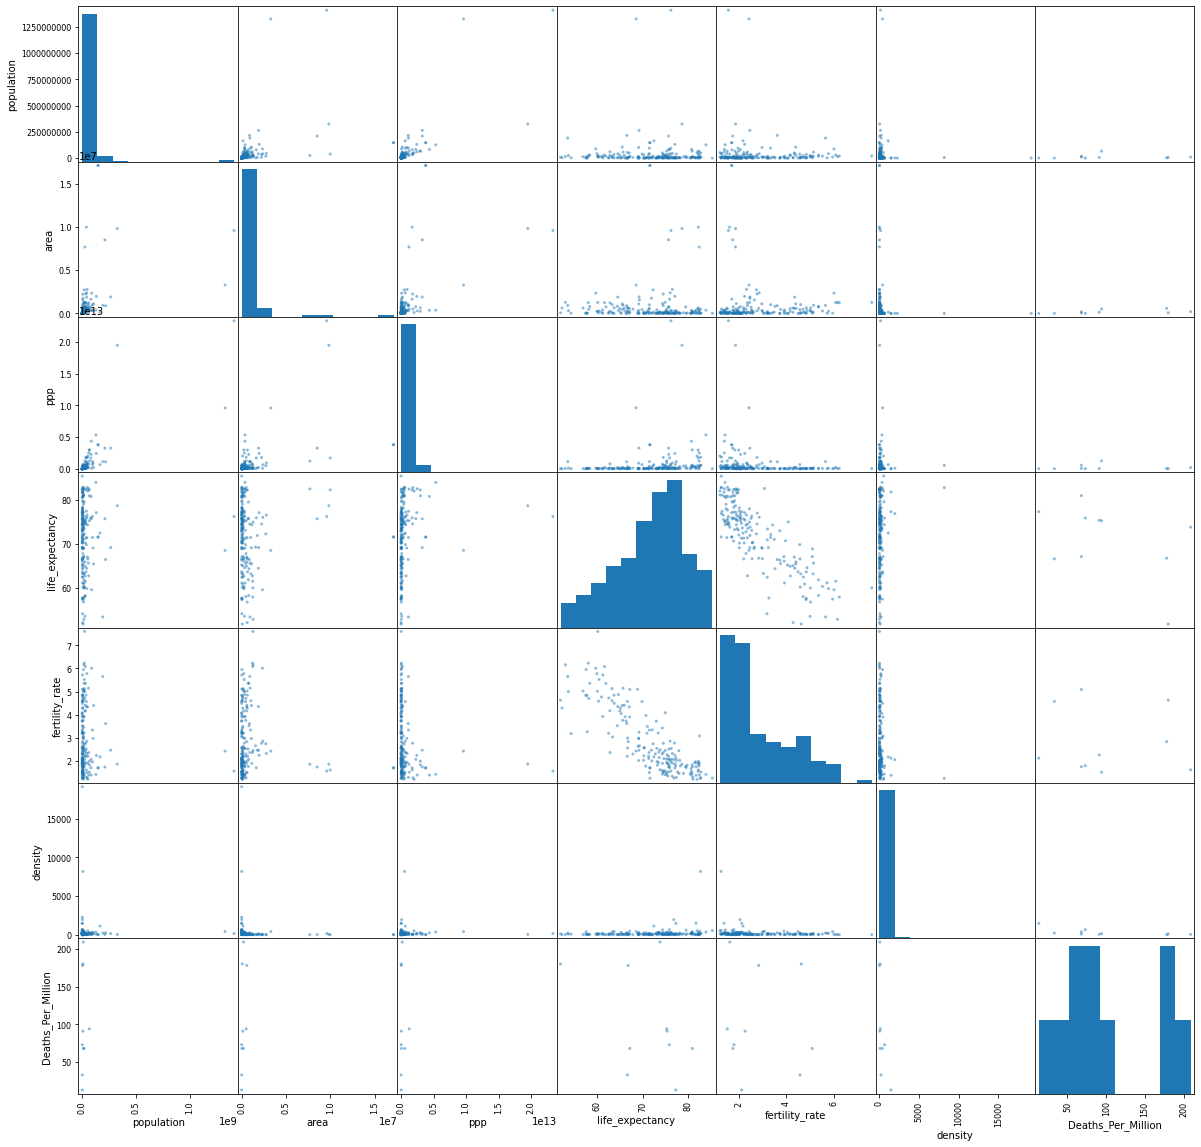

In [4]:
axes = pd.plotting.scatter_matrix(df, figsize=(20,20))